#Import Modules



In [20]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

#Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import train400 Dataset

In [ ]:
# images = []
# for i in range(9):
#   image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/00{}.png".format(i+1))
#   input_arr = tf.keras.preprocessing.image.img_to_array(image)
#   img = np.divide(input_arr, 255.0)
#   images.append(img)

# for i in range(10, 99):
#   image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/0{}.png".format(i))
#   input_arr = tf.keras.preprocessing.image.img_to_array(image)
#   img = np.divide(input_arr, 255.0)
#   images.append(img)

# for i in range(100, 400):
#   image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/{}.png".format(i))
#   input_arr = tf.keras.preprocessing.image.img_to_array(image)
#   img = np.divide(input_arr, 255.0)
#   images.append(img)

In [ ]:
# images = np.array(images)
# print(images.shape)

In [4]:
base_url = "/content/drive/MyDrive/datas/"
folders = ["train400", "LIVE1", "LIVE1_q10", "LIVE1_q20", "LIVE1_q30", "LIVE1_q40", "BSD68"]

In [5]:
import subprocess
images = []
for folder in folders:
  output = subprocess.check_output("ls " + base_url + folder, shell=True)
  print(type(output))
  files_list = output.decode('utf-8').split('\n')
  files_list.pop()

  for image in files_list:
    image_real = tf.keras.preprocessing.image.load_img(base_url + folder + "/" +image)
    image_real = image_real.resize((300,300))
    input_arr = tf.keras.preprocessing.image.img_to_array(image_real)
    #  input_arr = input_arr.reshape((180,180,3))
    img = np.divide(input_arr, 255.0)
    images.append(img)

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


In [6]:
images = np.array(images)
print(images.shape)

(613, 300, 300, 3)


#ADD NOISE TO IMAGE

In [7]:
tf.convert_to_tensor(img, dtype=None, dtype_hint=None, name=None)

import numpy as np
import os
import cv2
def noisy(image):
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

In [22]:
import numpy
noise_factor = 0.2
noisy_images = images + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=images.shape)
# x_test_noisy = X_test + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
x_train_noisy = numpy.clip(noisy_images, 0., 1.)
# x_test_noisy = numpy.clip(x_test_noisy, 0., 1.)

In [8]:
# image_noisy = []
# for img in images:
#   image_noisy.append(noisy(img))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(613, 300, 300, 3) (613, 300, 300, 3)


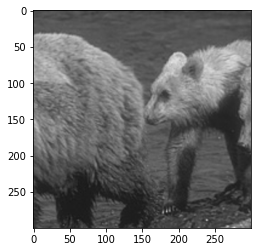

In [9]:
# image_noisy = np.array(image_noisy)
# image_noisy.shape
# plt.imshow(images[0].reshape(300,300,3))
# print(type(images), type(image_noisy))
# print(images.shape, image_noisy.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


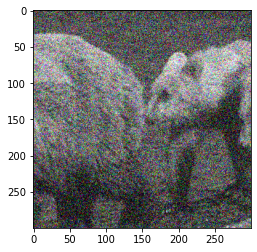

In [23]:
plt.imshow(noisy_images[0])

#CREATING TRAINING AND VALIDATION DATASET

In [24]:

train_images = images[0:500]
train_images_noisy = noisy_images[0:500]

val_images = images[500:613]
val_images_noisy = noisy_images[500:613]

print(train_images.shape, train_images_noisy.shape, val_images.shape, val_images_noisy.shape)

(500, 300, 300, 3) (500, 300, 300, 3) (113, 300, 300, 3) (113, 300, 300, 3)


#MODEL ARCHITECTURE

In [25]:
input = layers.Input(shape=(300, 300, 3))

In [26]:
# Encoder
def feature_extraction(input):
  # upper model
  x1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(input)
  x2 = layers.Conv2D(16, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(x1)

  # lower model
  y1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(input)
  y2 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(y1)

  # concat upper and lower model in feature extraction
  concatenated = tf.keras.layers.Concatenate(axis=-1)([x1, x2, y1, y2])

  return concatenated

In [27]:
# Start of feature integration
def feature_integration(concatenated):
  conc_conv1 = layers.Conv2D(32, (1, 1), activation="sigmoid", padding="same")(concatenated)

  x3 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(conc_conv1)
  x4 = layers.Conv2D(16, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(x3)

  # x4  = layers.Dropout(0.2)(x4)

  y3 = layers.Conv2D(16, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(conc_conv1)
  y4 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(y3)

  # y4  = layers.Dropout(0.2)(y4)

  concatenated2 = tf.keras.layers.Concatenate(axis=-1)([x3, x4, y3, y4])

  print(concatenated2.shape)

  conc_conv2 = layers.Conv2D(16, (1, 1), activation="relu", padding="same")(concatenated2)

  concatenated3 = tf.keras.layers.Concatenate(axis=-1)([conc_conv1, conc_conv2])

  print(concatenated3.shape)

  return concatenated3

In [28]:
# reconstruction
def reconstruction(concatenated3):
  x = layers.Conv2DTranspose(16, (3, 3), activation="relu", padding="same")(concatenated3)
  x = layers.Conv2DTranspose(16, (3, 3), activation="relu",  padding="same", dilation_rate=(2,2))(x)
  out = layers.Conv2D(3, (1, 1), activation="sigmoid", padding="same")(x)
  return out

In [45]:
#making the ddfn model
model = feature_extraction(input)
for _ in range(1):
  model = feature_integration(model)
out_1 = reconstruction(model)

model = feature_extraction(input)
for _ in range(3):
  model = feature_integration(model)
out_3 = reconstruction(model)

model = feature_extraction(input)
for _ in range(5):
  model = feature_integration(model)
out_5 = reconstruction(model)

model = feature_extraction(input)
for _ in range(7):
  model = feature_integration(model)
out_7 = reconstruction(model)

(None, 300, 300, 64)
(None, 300, 300, 48)
(None, 300, 300, 64)
(None, 300, 300, 48)
(None, 300, 300, 64)
(None, 300, 300, 48)
(None, 300, 300, 64)
(None, 300, 300, 48)


In [30]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [46]:
# running the model
import pickle
autoencoder1 = Model(input, out_1)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder1.compile(optimizer=opt, loss="binary_crossentropy")
autoencoder1.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history1 = autoencoder1.fit(x=train_images_noisy,y=train_images,epochs=15,batch_size=16,validation_data=(val_images_noisy, val_images))

filename = '1_layer.sav'
pickle.dump(autoencoder1, open(filename, 'wb'))

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_232 (Conv2D)            (None, 300, 300, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_234 (Conv2D)            (None, 300, 300, 16  448         ['input_2[0][0]']                
                                )                                                           

KeyboardInterrupt: ignored

In [ ]:
autoencoder3 = Model(input, out_3)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder3.compile(optimizer=opt, loss="binary_crossentropy", metrics = ['accuracy'])
autoencoder3.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history3 = autoencoder3.fit(x=train_images_noisy,y=train_images,epochs=100,batch_size=16,validation_data=(val_images_noisy, val_images))

filename = '3_layer.sav'
pickle.dump(autoencoder3, open(filename, 'wb'))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 300, 300, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 300, 300, 16  448         ['input_1[0][0]']                
                                )                                                           

In [ ]:
autoencoder5 = Model(input, out_5)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder5.compile(optimizer=opt, loss="binary_crossentropy", metrics = ['accuracy'])
autoencoder5.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history5 = autoencoder5.fit(x=train_images_noisy,y=train_images,epochs=100,batch_size=16,validation_data=(val_images_noisy, val_images))
filename = '5_layer.sav'
pickle.dump(autoencoder5, open(filename, 'wb'))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 300, 300, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 300, 300, 16  448         ['input_1[0][0]']                
                                )                                                           

In [ ]:
autoencoder7 = Model(input, out_7)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder7.compile(optimizer=opt, loss="binary_crossentropy", metrics = ['accuracy'])
autoencoder7.summary()
history7 = autoencoder7.fit(x=train_images_noisy,y=train_images,epochs=100,batch_size=16,validation_data=(val_images_noisy, val_images), callbacks = [early_stopping])
filename = '7_layer.sav'
pickle.dump(autoencoder7, open(filename, 'wb'))

#FITTING DATA

# Sharpen Image

#CREATING TEST DATASET

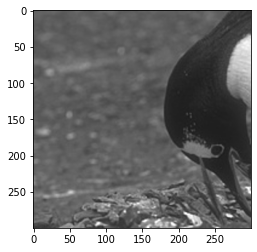

In [41]:
# test_image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/datas/train400/007.png")
# test_image = test_image.resize((300,300))
# input_arr = tf.keras.preprocessing.image.img_to_array(test_image)
# print(type(input_arr))
# test_image = np.divide(input_arr, 255.0)

plt.imshow(images[7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


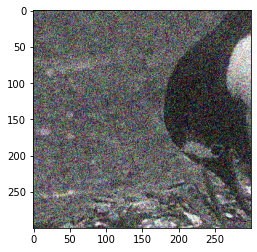

In [42]:
# test_image_noisy = noisy(test_image)
plt.imshow(noisy_images[7])

#PREDICTING MODEL

Output for 1 Layer


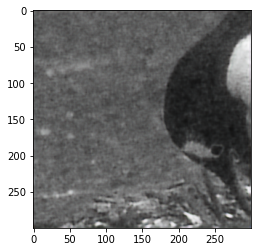

In [43]:
reco = autoencoder1.predict(noisy_images[7][None])[0]
plt.imshow(reco)

output for 3 layers

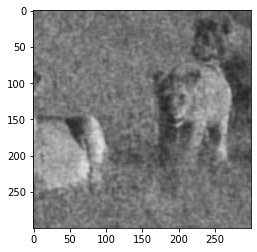

In [ ]:
reco = autoencoder3.predict(test_image_noisy[None])[0]
plt.imshow(reco)

output 5 layers


In [1]:
reco = autoencoder5.predict(test_image_noisy[None])[0]
plt.imshow(reco)

NameError: ignored

output 7 layers

In [ ]:
reco = autoencoder7.predict(test_image_noisy[None])[0]
plt.imshow(reco)

#PLOTTING GRAPH



In [ ]:
def plotting_graph(history,parameter):
  Y = []
  Z = []
  if parameter is "Loss":
    Y = np.array(history.history['loss'])
    Z = np.array(history.history['val_loss'])
  else:
    Y = np.array(history.history['accuracy'])
    Z = np.array(history.history['val_accuracy'])

  plt.plot(Y, color='r', label='training '+parameter)
  plt.plot(Z, color='g', label='validation '+parameter)
  plt.xlabel("Epochs")
  plt.ylabel(parameter)
  plt.title("{} vs Epoch".format(parameter))

  plt.legend()
  plt.show()

In [ ]:
plotting_graph(history,"Loss")
plotting_graph(history,"Accuracy")